## **Demand Trend Analysis and Transaction Conversion Rate for Providing Better Customer Satisfaction**

Ralali.com merupakan salah satu business unit terbesar yang ada di ekosistem Ralali (Ralali.com, R-Connect, R-Agent) yang bergerak sebagai Marketplace Platform dimana platform ini menghubungkan antara user (buyer dan seller) untuk model bisnis B2B di Indonesia. 

Ralali ingin mengembangkan bisnisnya dengan menyesuaikan targeted market yang dituju dengan mengetahui pola dalam transactional data yang biasa dicapture dari tahun ke tahun. Untuk penyesuaian tersebut Ralali juga harus memperhatikan bagaimana kepuasan user dalam menggunakan platformnya sehingga perlu dilakukan monitoring terhadap transaksi, salah satunya dengan perhitungan conversion rate dari setiap proses yang dilalui user dalam bertransaksi.

Adapun dalam analisis kali ini berfokus pada peningkatan metrics Gross Merchandise Value (GMV)

### **Get the Data**

In [ ]:
#importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
from google.cloud import bigquery
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load private key JSON from google drive
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/content/drive/MyDrive/Studi Independen - Bitlabs (Rizal)/private-key.json'

In [ ]:
#get the data
bqclient = bigquery.Client()

# Download query results.
query_string = """
WITH tabel_gab AS (
SELECT
  *
FROM
  `G_CID_01.ralali_transactions_Q1_2018`
UNION ALL
SELECT
  *
FROM
  `G_CID_01.ralali_transactions_Q1_2019`
UNION ALL
SELECT
  *
FROM
  `G_CID_01.ralali_transactions_Q1_2020`
), 

tabel_gabungan AS (
  SELECT *,
  (price * product_quantity) AS gmv,
  (((price * product_quantity)) * (percentage_commission/100)) AS revenue,
  CASE
    WHEN payment_datetime IS NOT NULL THEN 'Paid'
  ELSE
  'Not Paid'
END
  AS is_paid,
  CASE
    WHEN payment_datetime IS NOT NULL AND received_datetime IS NULL THEN 'Refund'
  ELSE
  'Non Refund'
END
  AS refund_status
FROM
  tabel_gab
)

SELECT
  *
FROM
  tabel_gabungan
WHERE
  refund_status = 'Non Refund'
"""

df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
    )
)

In [ ]:
#display data
df.head()

,order_id,oder_detail_id,order_datetime,item_id,item_name,cat_name,price,product_quantity,percentage_commission,payment_method,...,buyer_id,seller_id,order_source,buyer_province_name,buyer_city_name,logistic_name,gmv,revenue,is_paid,refund_status
0,vWtd1y0/6huGN2/XeVvDsuZQoDwatiNmUATDyiR+T176ru...,5F+Im4Nc+NUSZqLbx+X1eDrweIh5M0spYtS/UdcVA7aaJ+...,2018-01-24 23:08:46+00:00,FiwEDZtpOyYWv3+YJlwOSL3tBRSsNNNNDddisUbym/nJPF...,IC LOCK Alarm Sepeda Motor Tipe 1L 1 Sandi,Automotive & Transportation,70000.0,11,0.0,BCA Bank Transfer,...,4bS8qFKVzWcs1YbiN1AH69caS28RLKfoD9Sw5mhywcKLRy...,+4nL+1ptdvhVGUOs4XRPWrfX7udjVZHeHD5QumR31VzOzx...,website,Banten,Tangerang,SAP Express,770000.0,0.0,Paid,Non Refund
1,hYo6AokZ1bqrZlrc/eMvqqaODQGiv5/TmUFtzkYTuY5jDZ...,X1hbQ/Sk8go6uIIMeGCtodTT1RHe747Bfix4NRcsVSMVMw...,2018-03-12 15:18:13+00:00,GYSx7Gu3Wy/DC3c/QEHBotPs/OIE1QDfKwTyWqEHhb626J...,Sleeping Bag Ultralight Packing,"Beauty, Sport & Fashion",106900.0,11,0.0,BCA Bank Transfer,...,gIMTtuVLpqhxr1vGQUX7z/9BsLfyuIEsw9adNH5RFCmJoJ...,+7J29u1/MoqIdao5nXk+a154wh0xn5yHpNAlO+cMMagBg3...,website,Jawa Barat,Bandung,TIKI,1175900.0,0.0,Paid,Non Refund
2,aZYLoHJEF14rPOHWczVrCzZHEbwv72w9yVEOtCVNQoeA3+...,GR22NQrEEEj8H0xYK5+06Ivz/pw7kkM6PRfduolAeb2waS...,2018-02-01 20:16:19+00:00,GYSx7Gu3Wy/DC3c/QEHBotPs/OIE1QDfKwTyWqEHhb626J...,Sleeping Bag Ultralight Packing,"Beauty, Sport & Fashion",106900.0,11,0.0,Mandiri Bank Transfer,...,iAM0QYDk/thCNhc2NLA5XjAH/wCIcbwgWXK3DpWRfOiohn...,+7J29u1/MoqIdao5nXk+a154wh0xn5yHpNAlO+cMMagBg3...,website,Dki Jakarta,Jakarta Pusat,TIKI,1175900.0,0.0,Paid,Non Refund
3,aYEM8mBNtgtgtwiXy8o7KoVr7dD8S6remri7NnvTgFprLo...,I224XW2xDNCFAAe6UMFftC9alJNKABfKg9GKaNlLaYKyJI...,2018-01-15 15:49:58+00:00,GYSx7Gu3Wy/DC3c/QEHBotPs/OIE1QDfKwTyWqEHhb626J...,Sleeping Bag Ultralight Packing,"Beauty, Sport & Fashion",106900.0,11,0.0,BNI Bank Transfer,...,VNegkSBXo6FoVwuapctbPQhm52bDXytLzTfg4jeLYvUYZC...,+7J29u1/MoqIdao5nXk+a154wh0xn5yHpNAlO+cMMagBg3...,website,Banten,Tangerang,TIKI,1175900.0,0.0,Paid,Non Refund
4,fLtNp9wUwKF9DdhOTfsq9mBjgBiPGTYdIVIthaxC5klNh8...,4o+vKqCoSfwwEga/7WeHhYwpvRT9NN7G+u2yhnQuAiv+72...,2018-01-15 15:01:33+00:00,GYSx7Gu3Wy/DC3c/QEHBotPs/OIE1QDfKwTyWqEHhb626J...,Sleeping Bag Ultralight Packing,"Beauty, Sport & Fashion",106900.0,11,0.0,Credit Card,...,u+5n7OUaW4Az4ltUSf1kdFhb7aAbCYuQyNDuEDAQNucW5x...,+7J29u1/MoqIdao5nXk+a154wh0xn5yHpNAlO+cMMagBg3...,website,Dki Jakarta,Jakarta Barat,JNE,1175900.0,0.0,Paid,Non Refund


### **Handling Missing Value**

In [ ]:
#display info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53287 entries, 0 to 53286
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_id               53287 non-null  object             
 1   oder_detail_id         53287 non-null  object             
 2   order_datetime         53287 non-null  datetime64[ns, UTC]
 3   item_id                53287 non-null  object             
 4   item_name              53287 non-null  object             
 5   cat_name               53287 non-null  object             
 6   price                  53287 non-null  float64            
 7   product_quantity       53287 non-null  Int64              
 8   percentage_commission  53287 non-null  float64            
 9   payment_method         53287 non-null  object             
 10  payment_datetime       53287 non-null  datetime64[ns, UTC]
 11  processed_datetime     52398 non-null  datetime64[ns, 

In [ ]:
#checking missing value each columns
df.isnull().any()

order_id                 False
oder_detail_id           False
order_datetime           False
item_id                  False
item_name                False
cat_name                 False
price                    False
product_quantity         False
percentage_commission    False
payment_method           False
payment_datetime         False
processed_datetime        True
delivered_datetime        True
received_datetime        False
settled_datetime          True
buyer_id                 False
seller_id                False
order_source             False
buyer_province_name      False
buyer_city_name          False
logistic_name            False
gmv                      False
revenue                  False
is_paid                  False
refund_status            False
dtype: bool

In [ ]:
#handling missing value
df['processed_datetime'].fillna(df['payment_datetime'], inplace=True)
df['delivered_datetime'].fillna(df['payment_datetime'], inplace=True)
df['settled_datetime'].fillna(df['received_datetime'], inplace=True)
#convert datetime to year and month columns
df['Year'] = df['order_datetime'].dt.year
df['Month'] = df['order_datetime'].dt.month

In [ ]:
#display info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53287 entries, 0 to 53286
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   order_id               53287 non-null  object             
 1   oder_detail_id         53287 non-null  object             
 2   order_datetime         53287 non-null  datetime64[ns, UTC]
 3   item_id                53287 non-null  object             
 4   item_name              53287 non-null  object             
 5   cat_name               53287 non-null  object             
 6   price                  53287 non-null  float64            
 7   product_quantity       53287 non-null  Int64              
 8   percentage_commission  53287 non-null  float64            
 9   payment_method         53287 non-null  object             
 10  payment_datetime       53287 non-null  datetime64[ns, UTC]
 11  processed_datetime     53287 non-null  datetime64[ns, 

## **Data Transformation**

In [ ]:
#display categorical variable unique value
print(df['cat_name'].unique())
print(df['order_source'].unique())
print(df['logistic_name'].unique())
print(df['buyer_city_name'].unique())
print(df['payment_method'].unique())

['Automotive & Transportation' 'Beauty, Sport & Fashion'
 'Agriculture & Food' 'Furnitures & Decorations' 'Electronics'
 'Computer & Communication' 'Services' 'Office & Store Supplies' 'Horeca'
 'Building Materials' 'Machinery & Industrial Parts' 'Health & Medical']
['website' 'Android' 'ios' 'CMS' 'Web Ralali']
['SAP Express' 'TIKI' 'JNE' 'Free Ongkir Nusantara' 'Free Ongkir Lokal'
 'First Logistic' 'J&T' 'SiCepat' 'Ralali Kargo' 'RPX' 'Wahana' 'GO-SEND']
['Tangerang' 'Bandung' 'Jakarta Pusat' 'Jakarta Barat' 'Jakarta Utara'
 'Yogyakarta' 'Ciamis' 'Jakarta Selatan' 'Kendal' 'Tegal' 'Sidoarjo'
 'Surakarta (solo)' 'Blora' 'Sukabumi' 'Tangerang Selatan' 'Semarang'
 'Batang' 'Sleman' 'Blitar' 'Brebes' 'Jakarta Timur' 'Nganjuk'
 'Bandar Lampung' 'Kuningan' 'Singkawang' 'Gunung Kidul' 'Pekalongan'
 'Bekasi' 'Tuban' 'Surabaya' 'Klaten' 'Bogor' 'Malang' 'Cilegon' 'Depok'
 'Pematang Siantar' 'Kudus' 'Serang' 'Sawah Lunto' 'Indramayu' 'Gorontalo'
 'Badung' 'Pati' 'Palembang' 'Lumajang' 'Magetan

In [ ]:
#Replace string
df['order_source'] = df['order_source'].str.replace('Web Ralali', 'website')
df['payment_method'] = df['payment_method'].str.replace('BCA Bank Transfer', 'BCA')
df['payment_method'] = df['payment_method'].str.replace('Bank BCA', 'BCA')
df['payment_method'] = df['payment_method'].str.replace('BRI Bank Transfer', 'BRI')
df['payment_method'] = df['payment_method'].str.replace('Mandiri Bank Transfer', 'Mandiri')
df['payment_method'] = df['payment_method'].str.replace('Mandiri Internet Banking', 'Mandiri')
df['payment_method'] = df['payment_method'].str.replace('BNI Bank Transfer', 'BNI')

In [ ]:
#check unique value
print(df['payment_method'].unique())

['BCA' 'Mandiri' 'BNI' 'Credit Card' 'BRI' 'BII' 'Kredivo' 'Permata'
 'DBS Bank Transfer' 'Payment Nothing' 'Ovo' 'Ralali Wallet']


## **Data Description**

count    5.328700e+04
mean     1.102292e+07
std      6.920814e+07
min      1.210000e+05
25%      5.600000e+05
50%      1.320000e+06
75%      4.488625e+06
max      3.297360e+09
Name: gmv, dtype: float64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


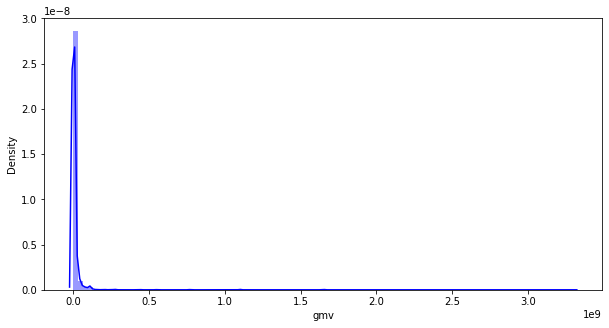

In [ ]:
#check statistics descriptive and distribution data of gmv
print(df['gmv'].describe())
plt.figure(figsize=(10, 5))
sns.distplot(df['gmv'], color='b', bins=100, hist_kws={'alpha': 0.4});

In [ ]:
#select variable numerical
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,price,product_quantity,percentage_commission,gmv,revenue,Year,Month
0,70000.0,11,0.0,770000.0,0.0,2018,1
1,106900.0,11,0.0,1175900.0,0.0,2018,3
2,106900.0,11,0.0,1175900.0,0.0,2018,2
3,106900.0,11,0.0,1175900.0,0.0,2018,1
4,106900.0,11,0.0,1175900.0,0.0,2018,1


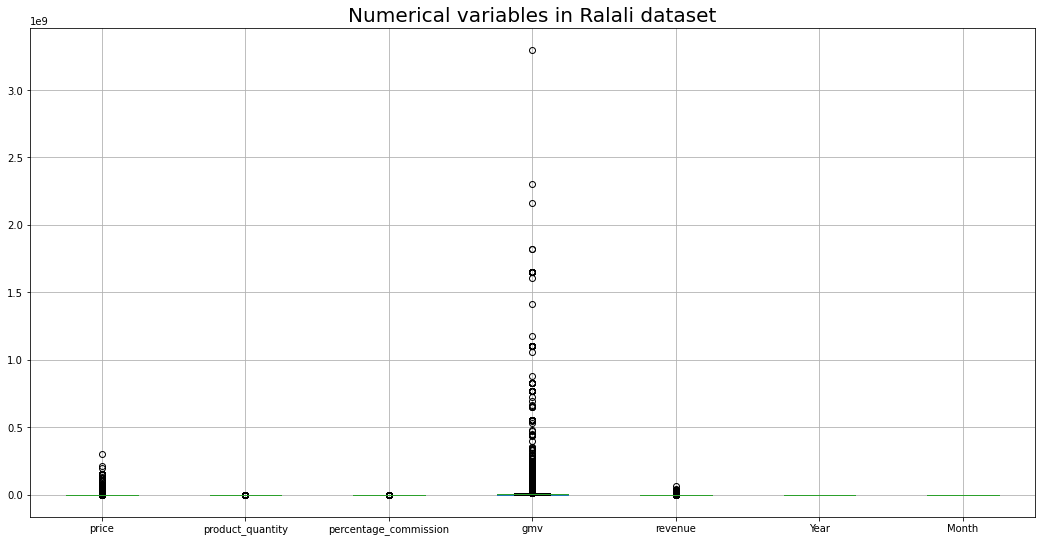

In [ ]:
#boxplot numerical variables
plt.figure(figsize=(18,9))
df_num.boxplot()
plt.title("Numerical variables in Ralali dataset", fontsize=20)
plt.show()

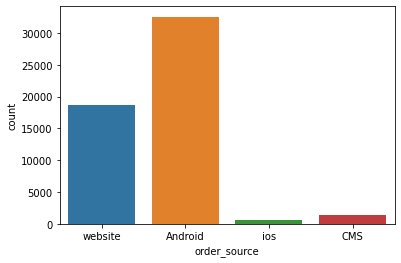

In [ ]:
#countplot frequency order_source 
sns.countplot(data = df, x = 'order_source')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

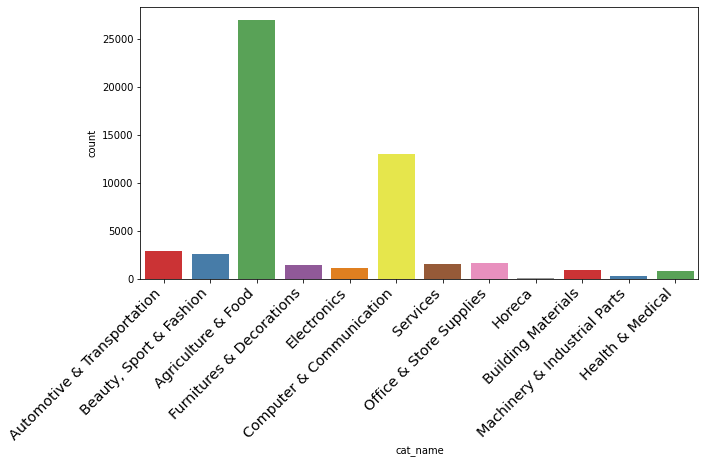

In [ ]:
#countplot frequency category product
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df,
    x='cat_name',
    palette='Set1'
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

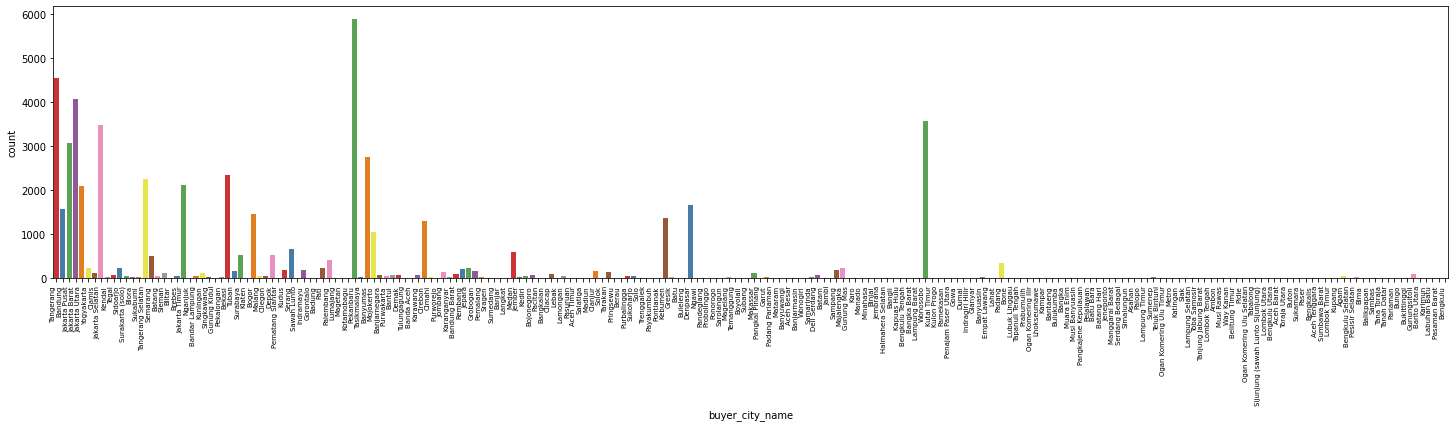

In [ ]:
#countplot frequency city
plt.figure(figsize=(25,5))
chart = sns.countplot(
    data=df,
    x='buyer_city_name',
    palette='Set1'
)

plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)

**Check Outlier**

In [ ]:
# Q1, Q3, dan IQR
Q1 = df['gmv'].quantile(0.25)
Q3 = df['gmv'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)
# Check ukuran sebelum data yang mengandung outliers dibuang
print('Shape awal: ', df.shape)
# Removing outliers
df_no_outliers = df[~((df['gmv'] < (Q1 - 1.5*IQR)) | (df['gmv'] > (Q3 + 1.5*IQR)))]
# Check ukuran  setelah data yang mengandung outliers dibuang
print('Shape akhir:', df_no_outliers.shape)

Q1:  560000.0
Q3:  4488625.0
IQR:  3928625.0
Shape awal:  (53287, 27)
Shape akhir: (43498, 27)


## **Exploratory Data Analysis**

In [ ]:
#Top Highest GMV by City 
print('The TOP 5 City with Highest GMV 2018-2020')
total_gmv = df.groupby(by=['buyer_city_name'], as_index=False)['gmv'].sum()
total_gmv.sort_values(by='gmv', ascending=False).head()

The TOP 5 City with Highest GMV 2018-2020


,buyer_city_name,gmv
77,Jakarta Barat,8.947453e+10
78,Jakarta Pusat,7.788777e+10
59,Deli Serdang,7.340092e+10
79,Jakarta Selatan,5.828404e+10
80,Jakarta Timur,4.432860e+10


In [ ]:
#Annual GMV by City
by_city = pd.pivot_table(df, values='gmv', index=['buyer_city_name'], columns=['Year'],
                    aggfunc=np.sum)
by_city

Year,2018,2019,2020
buyer_city_name,,,
Aceh Barat,NaN,13585000.0,NaN
Aceh Besar,935000.0,NaN,NaN
Aceh Tenggara,NaN,16610000.0,NaN
Aceh Timur,682000.0,NaN,NaN
Agam,NaN,18535000.0,1.126509e+08
...,...,...,...
Tulungagung,7813100.0,3643200.0,NaN
Way Kanan,NaN,10241000.0,NaN
Wonogiri,2721000.0,NaN,NaN


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

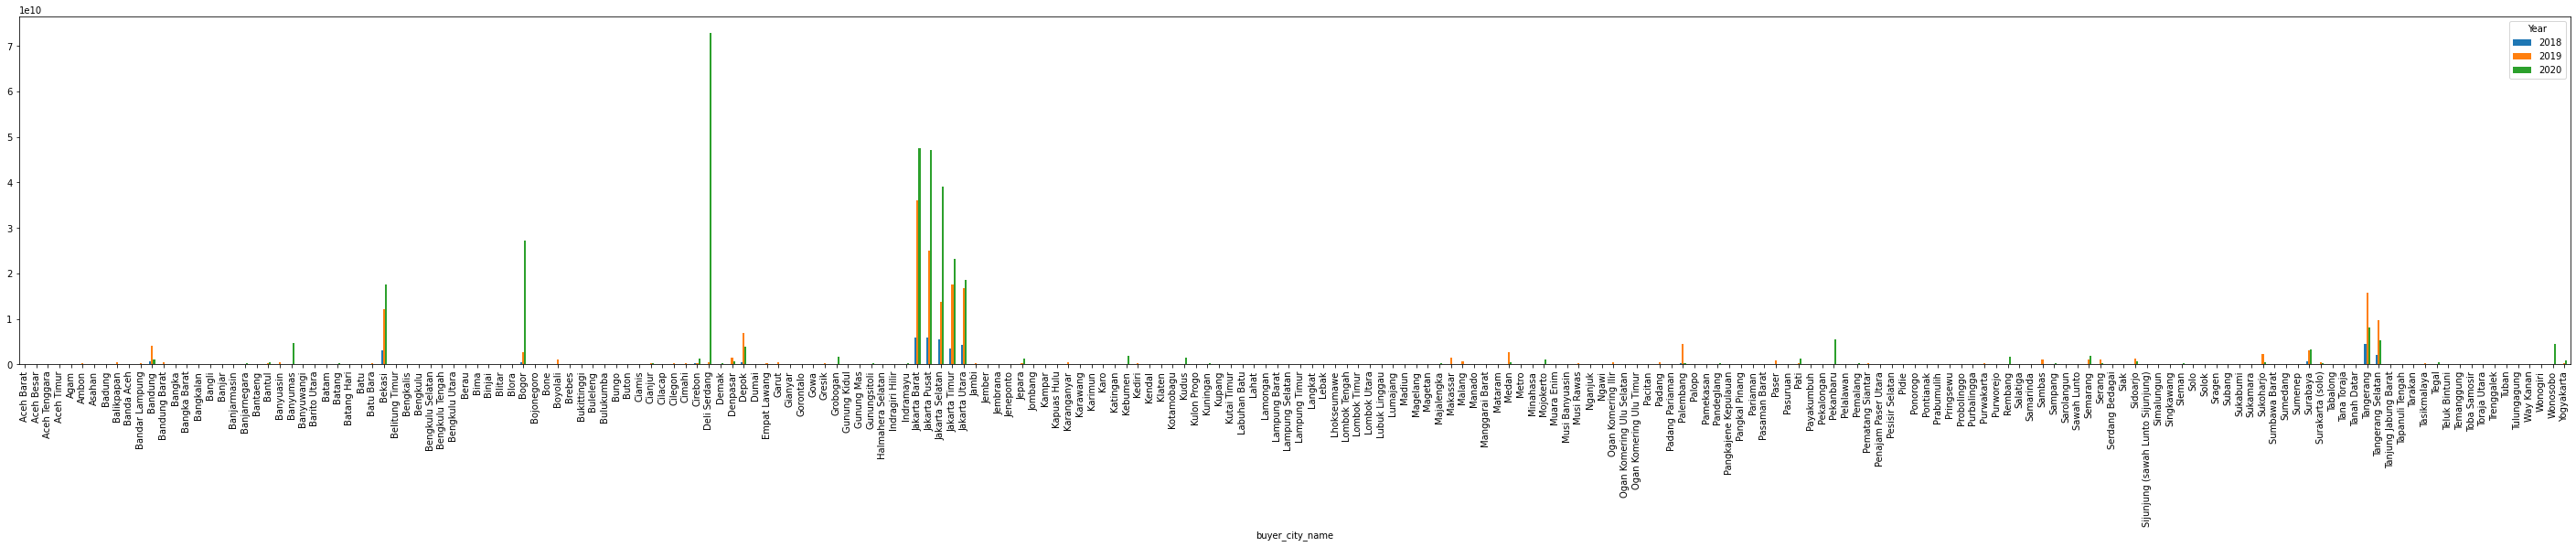

In [ ]:
#plot Annual GMV by City
by_city.plot(kind='bar', figsize=(50,7))
plt.xticks(rotation = 90)

**Insight**

Total GMV yang diterima Ralali mayoritas dihasilkan atau berasal dari Kota Besar. Wilayah di Jakarta menduduki peringkat teratas dalam akumulasi total GMV dari tahun 2018-2020

**Recommendations**

Perusahaan dapat memberikan promo berdasarkan segmentasi kota customers. Misalnya, pemberian promo ongkir atau promo harga untuk wilayah kota yang cukup jauh.

In [ ]:
#Top Highest GMV by Category Product
print('The TOP 5 Category Product with Highest GMV 2018-2020')
total_gmv = df.groupby(by=['cat_name'], as_index=False)['gmv'].sum()
total_gmv.sort_values(by='gmv', ascending=False).head()

The TOP 5 Category Product with Highest GMV 2018-2020


,cat_name,gmv
1,Automotive & Transportation,2.344586e+11
4,Computer & Communication,2.291960e+11
0,Agriculture & Food,4.526114e+10
9,Machinery & Industrial Parts,2.523135e+10
3,Building Materials,1.703003e+10


In [ ]:
#Annual GMV by Category Product
by_cat = pd.pivot_table(df, values='gmv', index=['cat_name'], columns=['Year'],
                    aggfunc=np.sum)
by_cat

Year,2018,2019,2020
cat_name,,,
Agriculture & Food,2.828971e+09,1.640189e+10,2.603028e+10
Automotive & Transportation,3.939726e+09,1.365179e+11,9.400095e+10
"Beauty, Sport & Fashion",5.045005e+09,1.270505e+08,6.328157e+08
Building Materials,2.724141e+09,1.905694e+09,1.240020e+10
Computer & Communication,1.065725e+10,1.661876e+10,2.019200e+11
Electronics,1.386191e+09,4.780912e+08,1.195905e+10
Furnitures & Decorations,8.340107e+09,5.227300e+06,5.772073e+08
Health & Medical,2.334130e+09,2.709807e+07,8.653879e+08
Horeca,6.446710e+07,7.557860e+07,4.592000e+05


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

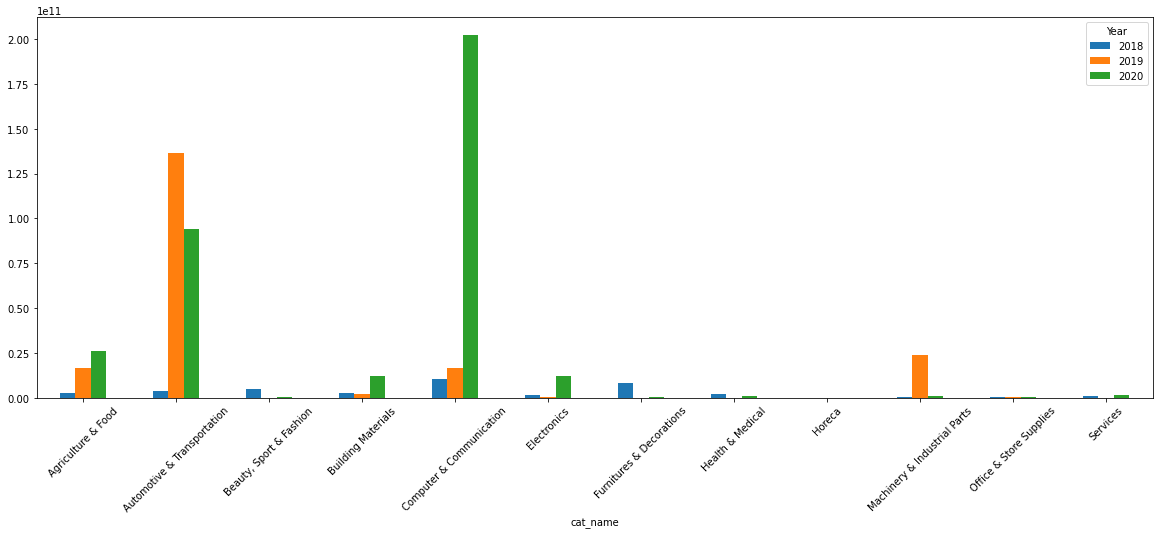

In [ ]:
#Plot Annual GMV by Category Product
by_cat.plot(kind='bar', figsize=(20,7))
plt.xticks(rotation = 45)

**Insight**

Kategori Product Automotive & Transportation menjadi product dengan akumulasi GMV tertinggi dari Q1 tahun 2018-2020.

**Recommendations**

Perusahaan dapat memberikan promo berdasarkan segmentasi kategori produk. Misalnya, perusahaan dapat memberi promo, diskon, atau menampilkan di menu utama untuk kategori yang masih sedikit peminatnya. Perusahaan juga bisa membuat pintasan atau product bundling untuk kategori product yang sering dibeli customers sehingga customers semakin mudah membeli productnya kembali.

In [ ]:
#GMV by Month
by_month = pd.pivot_table(df, values='gmv', index=['Month'], columns=['Year'],
                    aggfunc=np.sum)
by_month

Year,2018,2019,2020
Month,,,
1,7.644542e+09,6.434698e+10,2.212427e+11
2,1.276516e+10,4.284751e+10,4.360453e+10
3,1.888191e+10,8.951925e+10,8.652582e+10


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

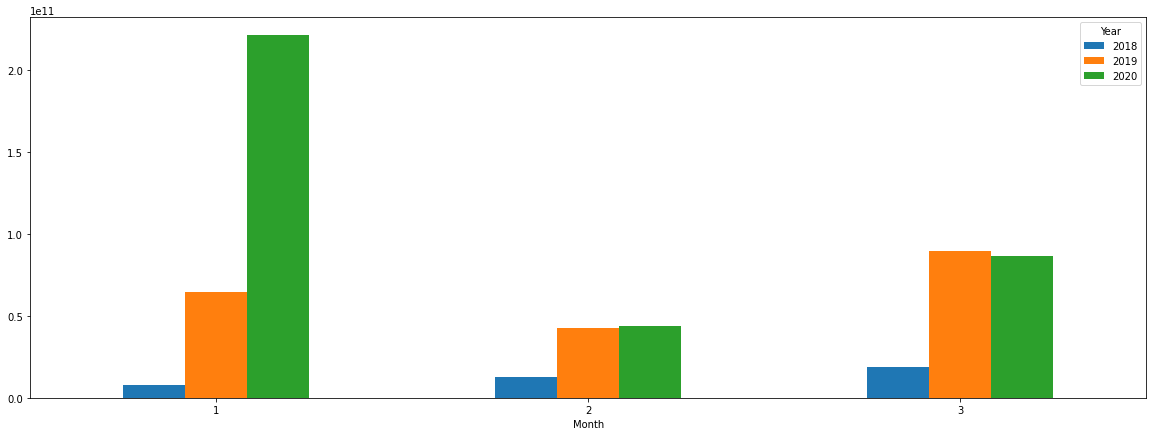

In [ ]:
#GMV by Month
by_month.plot(kind='bar', figsize=(20,7))
plt.xticks(rotation = 0)

**Insight**

Total GMV dari tahun ke tahun cenderung meningkat dengan nilai tertinggi berada pada bulan januari 2020.

**Recommendations**

Perusahaan dapat memberikan promo, reward, atau diskon untuk event tertentu yang ada pada setiap bulan.

In [ ]:
#GMV by Order Source
by_os = pd.pivot_table(df, values='gmv', index=['order_source'], columns=['Year'],
                    aggfunc=np.sum)
by_os

Year,2018,2019,2020
order_source,,,
Android,3.671050e+09,9.156003e+10,1.809517e+11
CMS,NaN,8.449566e+08,9.300644e+08
ios,3.895010e+07,1.339431e+10,1.190903e+09
website,3.558161e+10,9.091444e+10,1.683003e+11


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

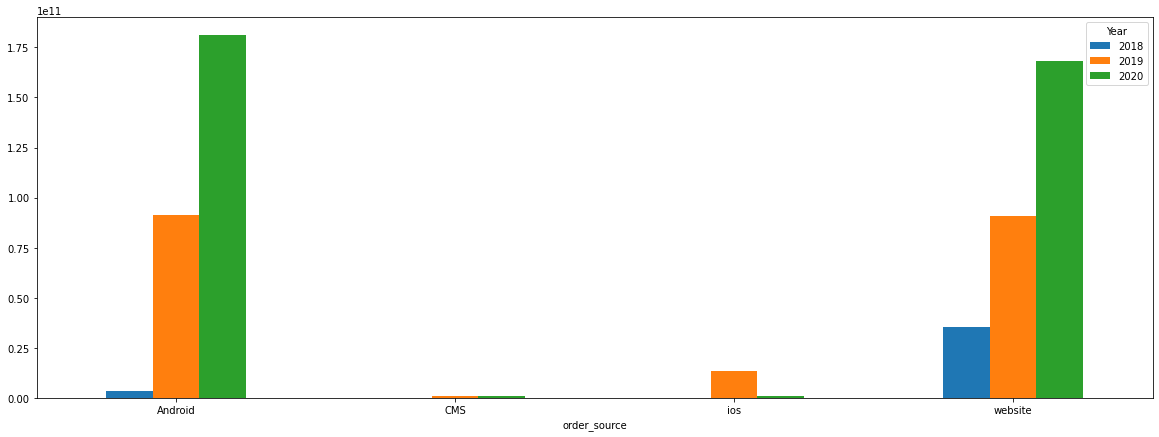

In [ ]:
#GMV by OS
by_os.plot(kind='bar', figsize=(20,7))
plt.xticks(rotation = 0)

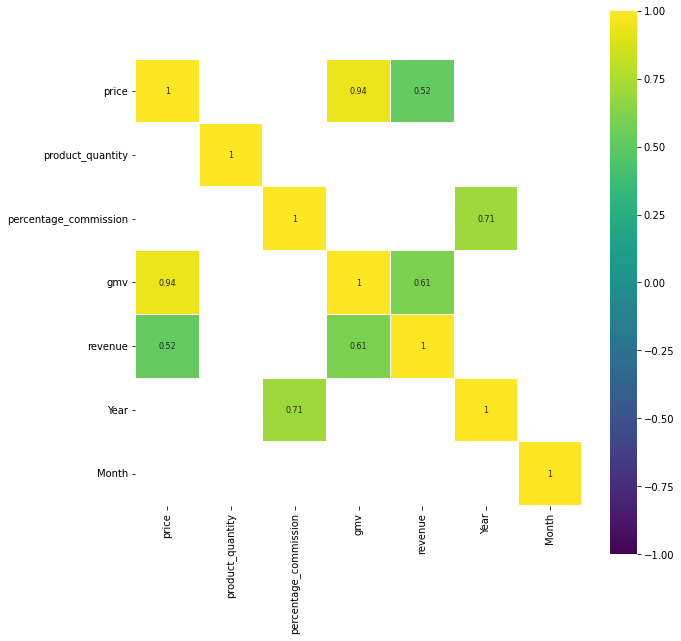

In [ ]:
#checking correlation between numerical variables
corr = df_no_outliers.select_dtypes(include = ['float64', 'int64']).corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Insight

GMV berkorelasi positif kuat dengan revenue dan juga price.

Recommendations

Perusahaan dapat menaikkan sedikit harga barang untuk product yang sering dibeli customers sehingga dapat meningkatkan GMV.

In [ ]:
#filter data
df3 = df_no_outliers[['order_source', 'gmv']]
df3.head()

,order_source,gmv
0,website,770000.0
1,website,1175900.0
2,website,1175900.0
3,website,1175900.0
4,website,1175900.0


In [ ]:
#Transform data to create dummy variable
df3["android"] = np.where(df3['order_source']=='Android', 1, 0) #D1 for Android
df3["website"] = np.where(df3['order_source']=='website', 1, 0) #D2 for Website
df3["ios"] = np.where(df3['order_source']=='ios', 1, 0) #D3 for ios
df3.head()

<ipython-input-31-2e20dfc7dfdd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["android"] = np.where(df3['order_source']=='Android', 1, 0) #D1 for Android
<ipython-input-31-2e20dfc7dfdd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["website"] = np.where(df3['order_source']=='website', 1, 0) #D2 for Website
<ipython-input-31-2e20dfc7dfdd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,order_source,gmv,android,website,ios
0,website,770000.0,0,1,0
1,website,1175900.0,0,1,0
2,website,1175900.0,0,1,0
3,website,1175900.0,0,1,0
4,website,1175900.0,0,1,0


In [ ]:
#define variable dependent and independent
x = df3[['android','website', 'ios']]
y = df3['gmv']

In [ ]:
#build regression model
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 1278399.7514792902
Coefficients: 
 [  -7244.66011162 1058810.92474199   58420.31799055]
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1220.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:00:26   Log-Likelihood:            -6.8565e+05
No. Observations:               43498   AIC:                         1.371e+06
Df Residuals:                   43494   BIC:                         1.371e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dengan mengambil taraf signifikansi 5%

Secara stimultan, jenis platform berperan terhadap GMV secara signifikan (p-value < 0.05). Diperoleh juga peran jenis platform terhadap GMV yaitu 7,8% ( R-Squared = 0.078) sedangkan sisanya dipengaruhi oleh variabel lain yang tidak dijelaskan dalam model.

Secara parsial, variabel dummy website berperan signifikan (p-value < 0.05). Pada variabel dummy website memiliki nilai GMV yang lebih tinggi dari platform yang lain. Sehingga ada perbedaan dari jenis platform terhadap nilai GMV.

## **Conclusion**
Terdapat pengaruh dari jenis platform yang digunakan customers terhadap nilai GMV. Adapun langkah yang perlu dilakukan agar meningkatkan GMV dari berbagai platform sebagai berikut.

1. Melakukan pengoptimalan kualitas semua platform ralali agar customers mendapatkan experience yang sama dalam setiap platform yang digunakan.

2. Memberi perlakuan yang berbeda kepada customers untuk setiap platform. Misalkan memberi promo untuk setiap instalasi aplikasi Ralali di Android atau ios sehingga branding dari ralali bisa ikut meningkat.

3. Memberikan pelayanan terbaik seperti pemberian diskon, pengiriman gratis, dan sebagainya